In [1]:
# This notebook is to make Figure S1 and S2 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

In [2]:
##mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8781 --memory-limit=60e9
from dask.distributed import Client
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_1/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:39476 Dashboard: http://203.247.189.225:8781/status,Cluster Workers: 5 Cores: 90 Memory: 300.00 GB


### import & read

In [3]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd
import netCDF4
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmaps

import glob
import os
from datetime import datetime
today = datetime.today()
import string

from tqdm.notebook import tqdm_notebook

In [4]:
exceptcv=['time','transport_regions','moc_components','moc_z','lat_aux_grid','MOC','dz']
def process_coords(ds, drop=True, except_coord_vars=exceptcv):    
    """Drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
          
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
scenarios=('HIST','SSP370')
members_cmip = ('1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007','1141.008','1161.009','1181.010',
                '1231.001','1231.002','1231.003','1231.004','1231.005','1231.006','1231.007','1231.008','1231.009','1231.010',
                '1251.001','1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008','1251.009','1251.010',
                '1281.001','1281.002','1281.003','1281.004','1281.005','1281.006','1281.007','1281.008','1281.009','1281.010',
                '1301.001','1301.002','1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010')
members_smbb = ('1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010',
                '1231.011','1231.012','1231.013','1231.014','1231.015','1231.016','1231.017','1231.018','1231.019','1231.020',
                '1251.011','1251.012','1251.013','1251.014','1251.015','1251.016','1251.017','1251.018','1251.019','1251.020',
                '1281.011','1281.012','1281.013','1281.014','1281.015','1281.016','1281.017','1281.018','1281.019','1281.020',
                '1301.011','1301.012','1301.013','1301.014','1301.015','1301.016','1301.017','1301.018','1301.019','1301.020')
members=members_cmip + members_smbb
ensembles = [ens for ens in range(len(members))]

In [6]:
var ='MOC'
ens_files=[]
for member in members :
    files=[]
    for scenario in scenarios :
        in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'/ocn/proc/tseries/month_1/'
        fsc=scenario
        fn = 'b.e21.B'+fsc+'*.f09_g17.LE2-'+member+'.pop.h.'
        files += glob.glob(in_dir+fn+var+'.*.nc')
        files = sorted(files)

    ens_files.append(files)

In [7]:
for i in range(len(members)):
    if len(ens_files[i])!=26:
        print(members[i],len(ens_files[i]))

In [8]:
ds=xr.open_mfdataset(ens_files,chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],
                     parallel='True',preprocess=process_coords,decode_cf=True,decode_times=True)
time_new=xr.cftime_range(start='1850',end='2101',freq='1M',calendar='noleap')
ds=ds.assign_coords(time=time_new)
ds

,Array,Chunk
Bytes,346.98 MB,138.24 kB
Shape,"(3012, 100, 3)","(120, 1, 3)"
Count,15600 Tasks,2600 Chunks
Type,|S384,numpy.ndarray
,Array,Chunk
Bytes,231.32 MB,92.16 kB
Shape,"(3012, 100, 2)","(120, 1, 2)"
Count,15600 Tasks,2600 Chunks
Type,|S384,numpy.ndarray
,Array,Chunk


In [9]:
print(ds.lat_aux_grid[274].values)

26.273556


In [10]:
ts=ds.MOC.isel(transport_reg=1,lat_aux_grid=274).sum(dim='moc_comp').sel(moc_z=slice(20000.,600000.)).max(dim='moc_z').load()
ts

<xarray.DataArray 'MOC' (concat_dim: 100, time: 3012)>
array([[20.905857 , 20.564505 , 11.207929 , ...,  7.4522285,  9.277337 ,
        10.070424 ],
       [22.6512   , 19.32667  , 18.104343 , ...,  6.7227817,  7.8800325,
         6.2566967],
       [22.207863 , 19.482008 , 18.724981 , ...,  4.7734194,  8.683013 ,
         9.683648 ],
       ...,
       [22.16287  , 16.518698 , 17.149937 , ...,  8.020134 , 11.235318 ,
        11.331073 ],
       [19.539896 , 20.693022 , 14.539906 , ...,  8.864095 ,  9.07568  ,
        11.465901 ],
       [19.652697 , 15.589047 , 12.882992 , ...,  6.8132424, 10.072748 ,
        10.47134  ]], dtype=float32)
Coordinates:
    lat_aux_grid  float32 26.27
  * time          (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * concat_dim    (concat_dim) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99

### plot

In [18]:
macro0=[0,1,2,3,4,5,6,7,8,9,50,51,52,53,54,55,56,57,58,59]
micro1=[10,11,12,13,14,15,16,17,18,19,60,61,62,63,64,65,66,67,68,69]
micro2=[20,21,22,23,24,25,26,27,28,29,70,71,72,73,74,75,76,77,78,79]
micro3=[30,31,32,33,34,35,36,37,38,39,80,81,82,83,84,85,86,87,88,89]
micro4=[40,41,42,43,44,45,46,47,48,49,90,91,92,93,94,95,96,97,98,99]

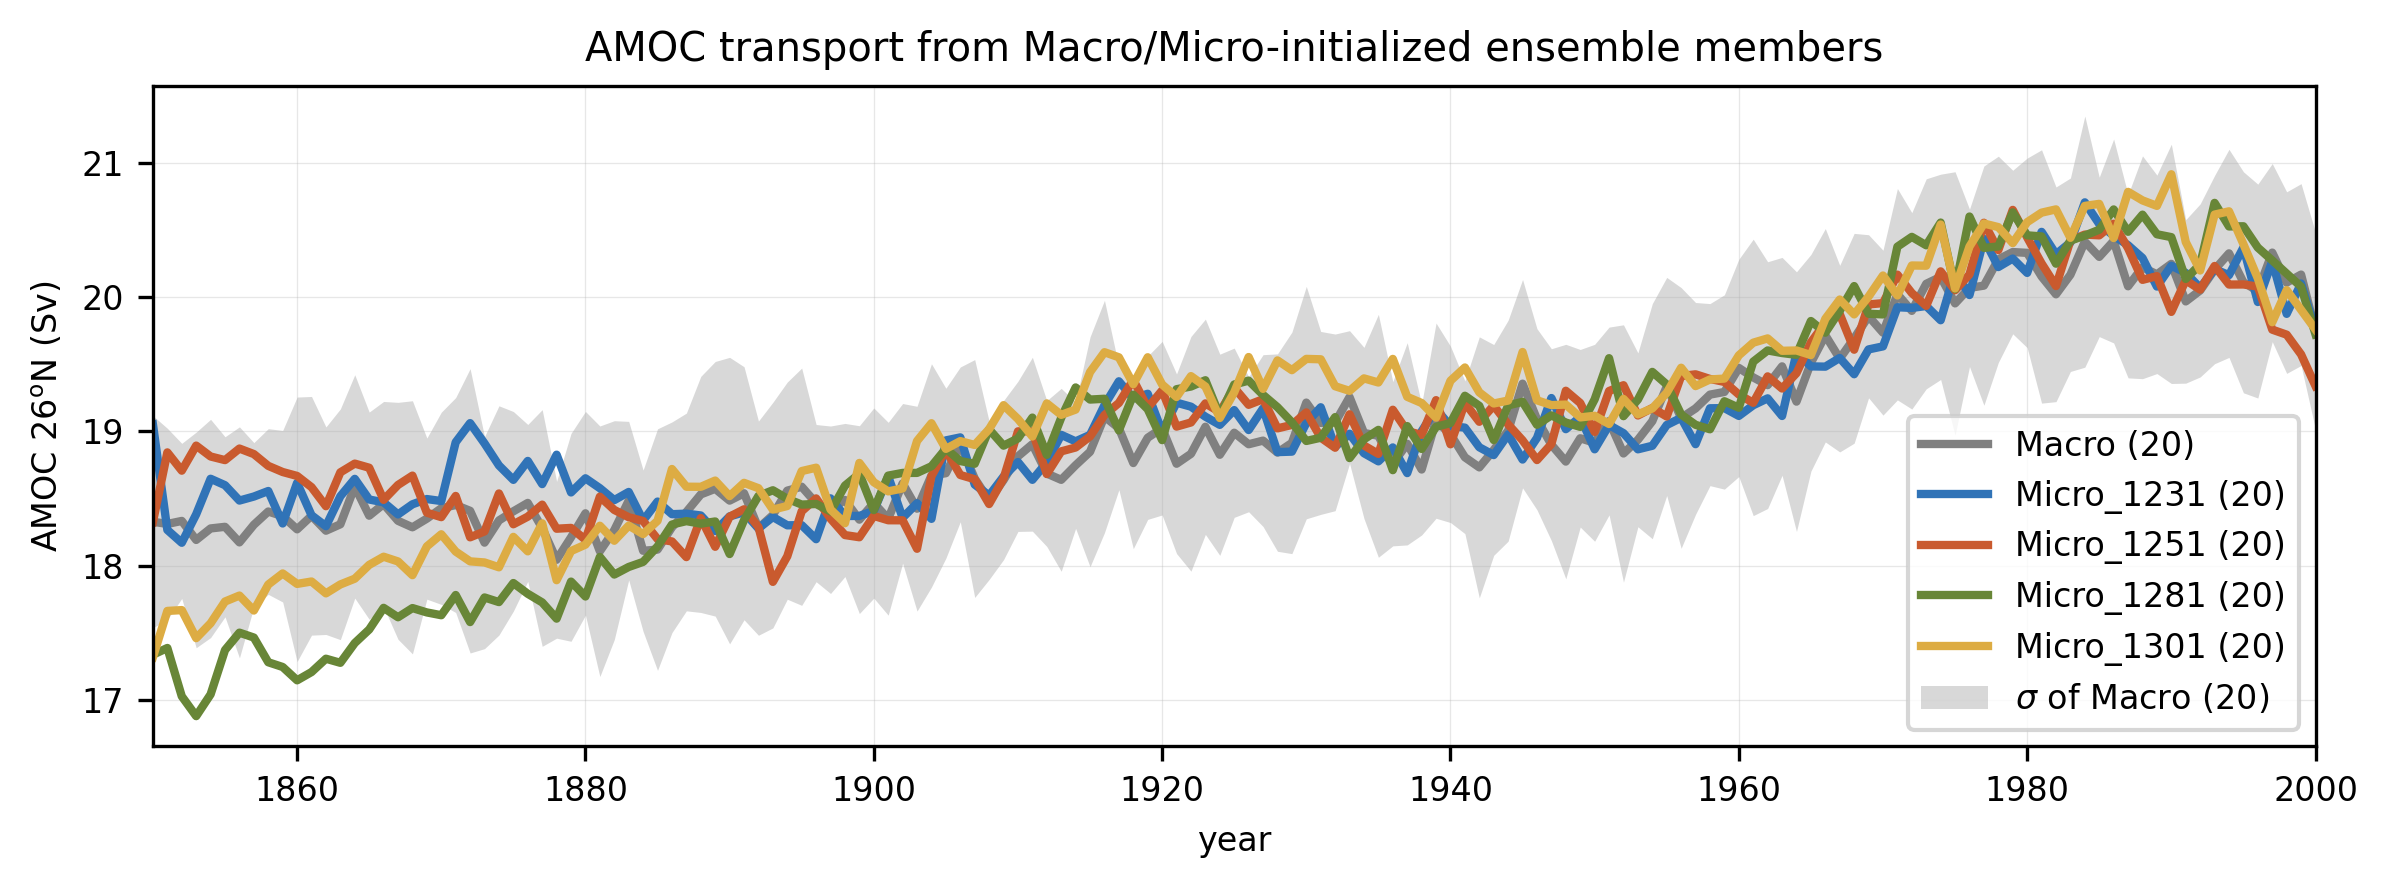

In [25]:
plt.rcParams.update({'font.size': 8,'hatch.linewidth': 0.5})
fig,ax=plt.subplots(1,1,figsize=(8,3),dpi=300,facecolor='w')

syr,eyr=1850,2000

ts_macro0=ts.isel(concat_dim=macro0).groupby('time.year').mean().sel(year=slice(syr,eyr))
ts_micro1=ts.isel(concat_dim=micro1).groupby('time.year').mean().sel(year=slice(syr,eyr))
ts_micro2=ts.isel(concat_dim=micro2).groupby('time.year').mean().sel(year=slice(syr,eyr))
ts_micro3=ts.isel(concat_dim=micro3).groupby('time.year').mean().sel(year=slice(syr,eyr))
ts_micro4=ts.isel(concat_dim=micro4).groupby('time.year').mean().sel(year=slice(syr,eyr))

ts_macro0.mean('concat_dim').plot.line(ax=ax,x='year',add_legend=False,color='gray'   ,lw=2,label='Macro (20)')
ts_micro1.mean('concat_dim').plot.line(ax=ax,x='year',add_legend=False,color='#3073b7',lw=2,label='Micro_1231 (20)')
ts_micro2.mean('concat_dim').plot.line(ax=ax,x='year',add_legend=False,color='#c95a2e',lw=2,label='Micro_1251 (20)')
ts_micro3.mean('concat_dim').plot.line(ax=ax,x='year',add_legend=False,color='#688637',lw=2,label='Micro_1281 (20)')
ts_micro4.mean('concat_dim').plot.line(ax=ax,x='year',add_legend=False,color='#ddac43',lw=2,label='Micro_1301 (20)')

ax.fill_between(ts_macro0.year,ts_macro0.mean('concat_dim')-1*ts_macro0.std('concat_dim'),ts_macro0.mean('concat_dim')+1*ts_macro0.std('concat_dim'),
                   color='gray',linewidth=0,alpha=0.3,label='$\sigma$ of Macro (20)')

#for i,a in enumerate(ax):
ax.set_title('AMOC transport from Macro/Micro-initialized ensemble members')
ax.set_ylabel('AMOC 26$^{\mathrm{o}}$N (Sv)')
ax.set_xlim(syr,eyr)
ax.legend(loc='lower right')
ax.grid(linewidth=0.3,alpha=0.3)
#ax.text(0.00,1.05,'a', fontsize = 10, ha='center', va='center', fontweight='bold', transform=ax.transAxes)

plt.tight_layout()
#plt.show()
plt.savefig('/home/ryamaguchi/tmp_fig/AMOC_initial.pdf')

### pi-controll

In [11]:
files = []
files += glob.glob('/proj/shared_data/ensemble_simulations/cesm2LE_PREINDUSTRIAL/ENS.101/ocn/MOC/monthly/data/*.nc')
files = sorted(files)

In [12]:
ds_pi=xr.open_mfdataset(files,chunks={'time':1200},combine='nested',concat_dim=['time'],
                        parallel='True',preprocess=process_coords,decode_cf=True,decode_times=True)
time_new_pi=xr.cftime_range(start='0001',end='2001',freq='1M',calendar='noleap')
ds_pi=ds_pi.assign_coords(time=time_new_pi)

In [13]:
ds_pi

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 24000, transport_reg: 2, z_t: 60)
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * time               (time) object 0001-01-31 00:00:00 ... 2000-12-31 00:00:00
Dimensions without coordinates: moc_comp, transport_reg, z_t
Data variables:
    moc_components     (time, moc_comp) |S384 dask.array<chunksize=(1188, 3), meta=np.ndarray>
    transport_regions  (time, transport_reg) |S384 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    dz                 (time, z_t) float32 dask.array<chunksize=(1188, 60), meta=np.ndarray>
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 dask.array<chunksize=(1188, 2, 3, 61, 395), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [14]:
ts_pi=ds_pi.MOC.isel(transport_reg=1,lat_aux_grid=274).sum(dim='moc_comp').sel(moc_z=slice(20000.,600000.)).max(dim='moc_z').load()
ts_pi

<xarray.DataArray 'MOC' (time: 24000)>
array([20.638617, 17.578075, 12.907548, ..., 16.351542, 18.116365,
       20.21728 ], dtype=float32)
Coordinates:
    lat_aux_grid  float32 26.27
  * time          (time) object 0001-01-31 00:00:00 ... 2000-12-31 00:00:00

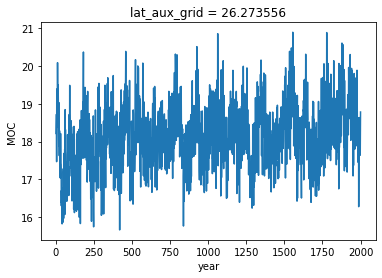

In [15]:
ts_pi.groupby('time.year').mean().plot();

In [16]:
macro0=[0,1,2,3,4,5,6,7,8,9,50,51,52,53,54,55,56,57,58,59]
micro1=[10,11,12,13,14,15,16,17,18,19,60,61,62,63,64,65,66,67,68,69]
micro2=[20,21,22,23,24,25,26,27,28,29,70,71,72,73,74,75,76,77,78,79]
micro3=[30,31,32,33,34,35,36,37,38,39,80,81,82,83,84,85,86,87,88,89]
micro4=[40,41,42,43,44,45,46,47,48,49,90,91,92,93,94,95,96,97,98,99]

ts_macro0=ts.isel(concat_dim=macro0).groupby('time.year').mean()
ts_micro1=ts.isel(concat_dim=micro1).groupby('time.year').mean()
ts_micro2=ts.isel(concat_dim=micro2).groupby('time.year').mean()
ts_micro3=ts.isel(concat_dim=micro3).groupby('time.year').mean()
ts_micro4=ts.isel(concat_dim=micro4).groupby('time.year').mean()

ts_micro1 = ts_micro1.assign_coords(year=np.arange(1231,1231+251))
ts_micro2 = ts_micro2.assign_coords(year=np.arange(1251,1251+251))
ts_micro3 = ts_micro3.assign_coords(year=np.arange(1281,1281+251))
ts_micro4 = ts_micro4.assign_coords(year=np.arange(1301,1301+251))

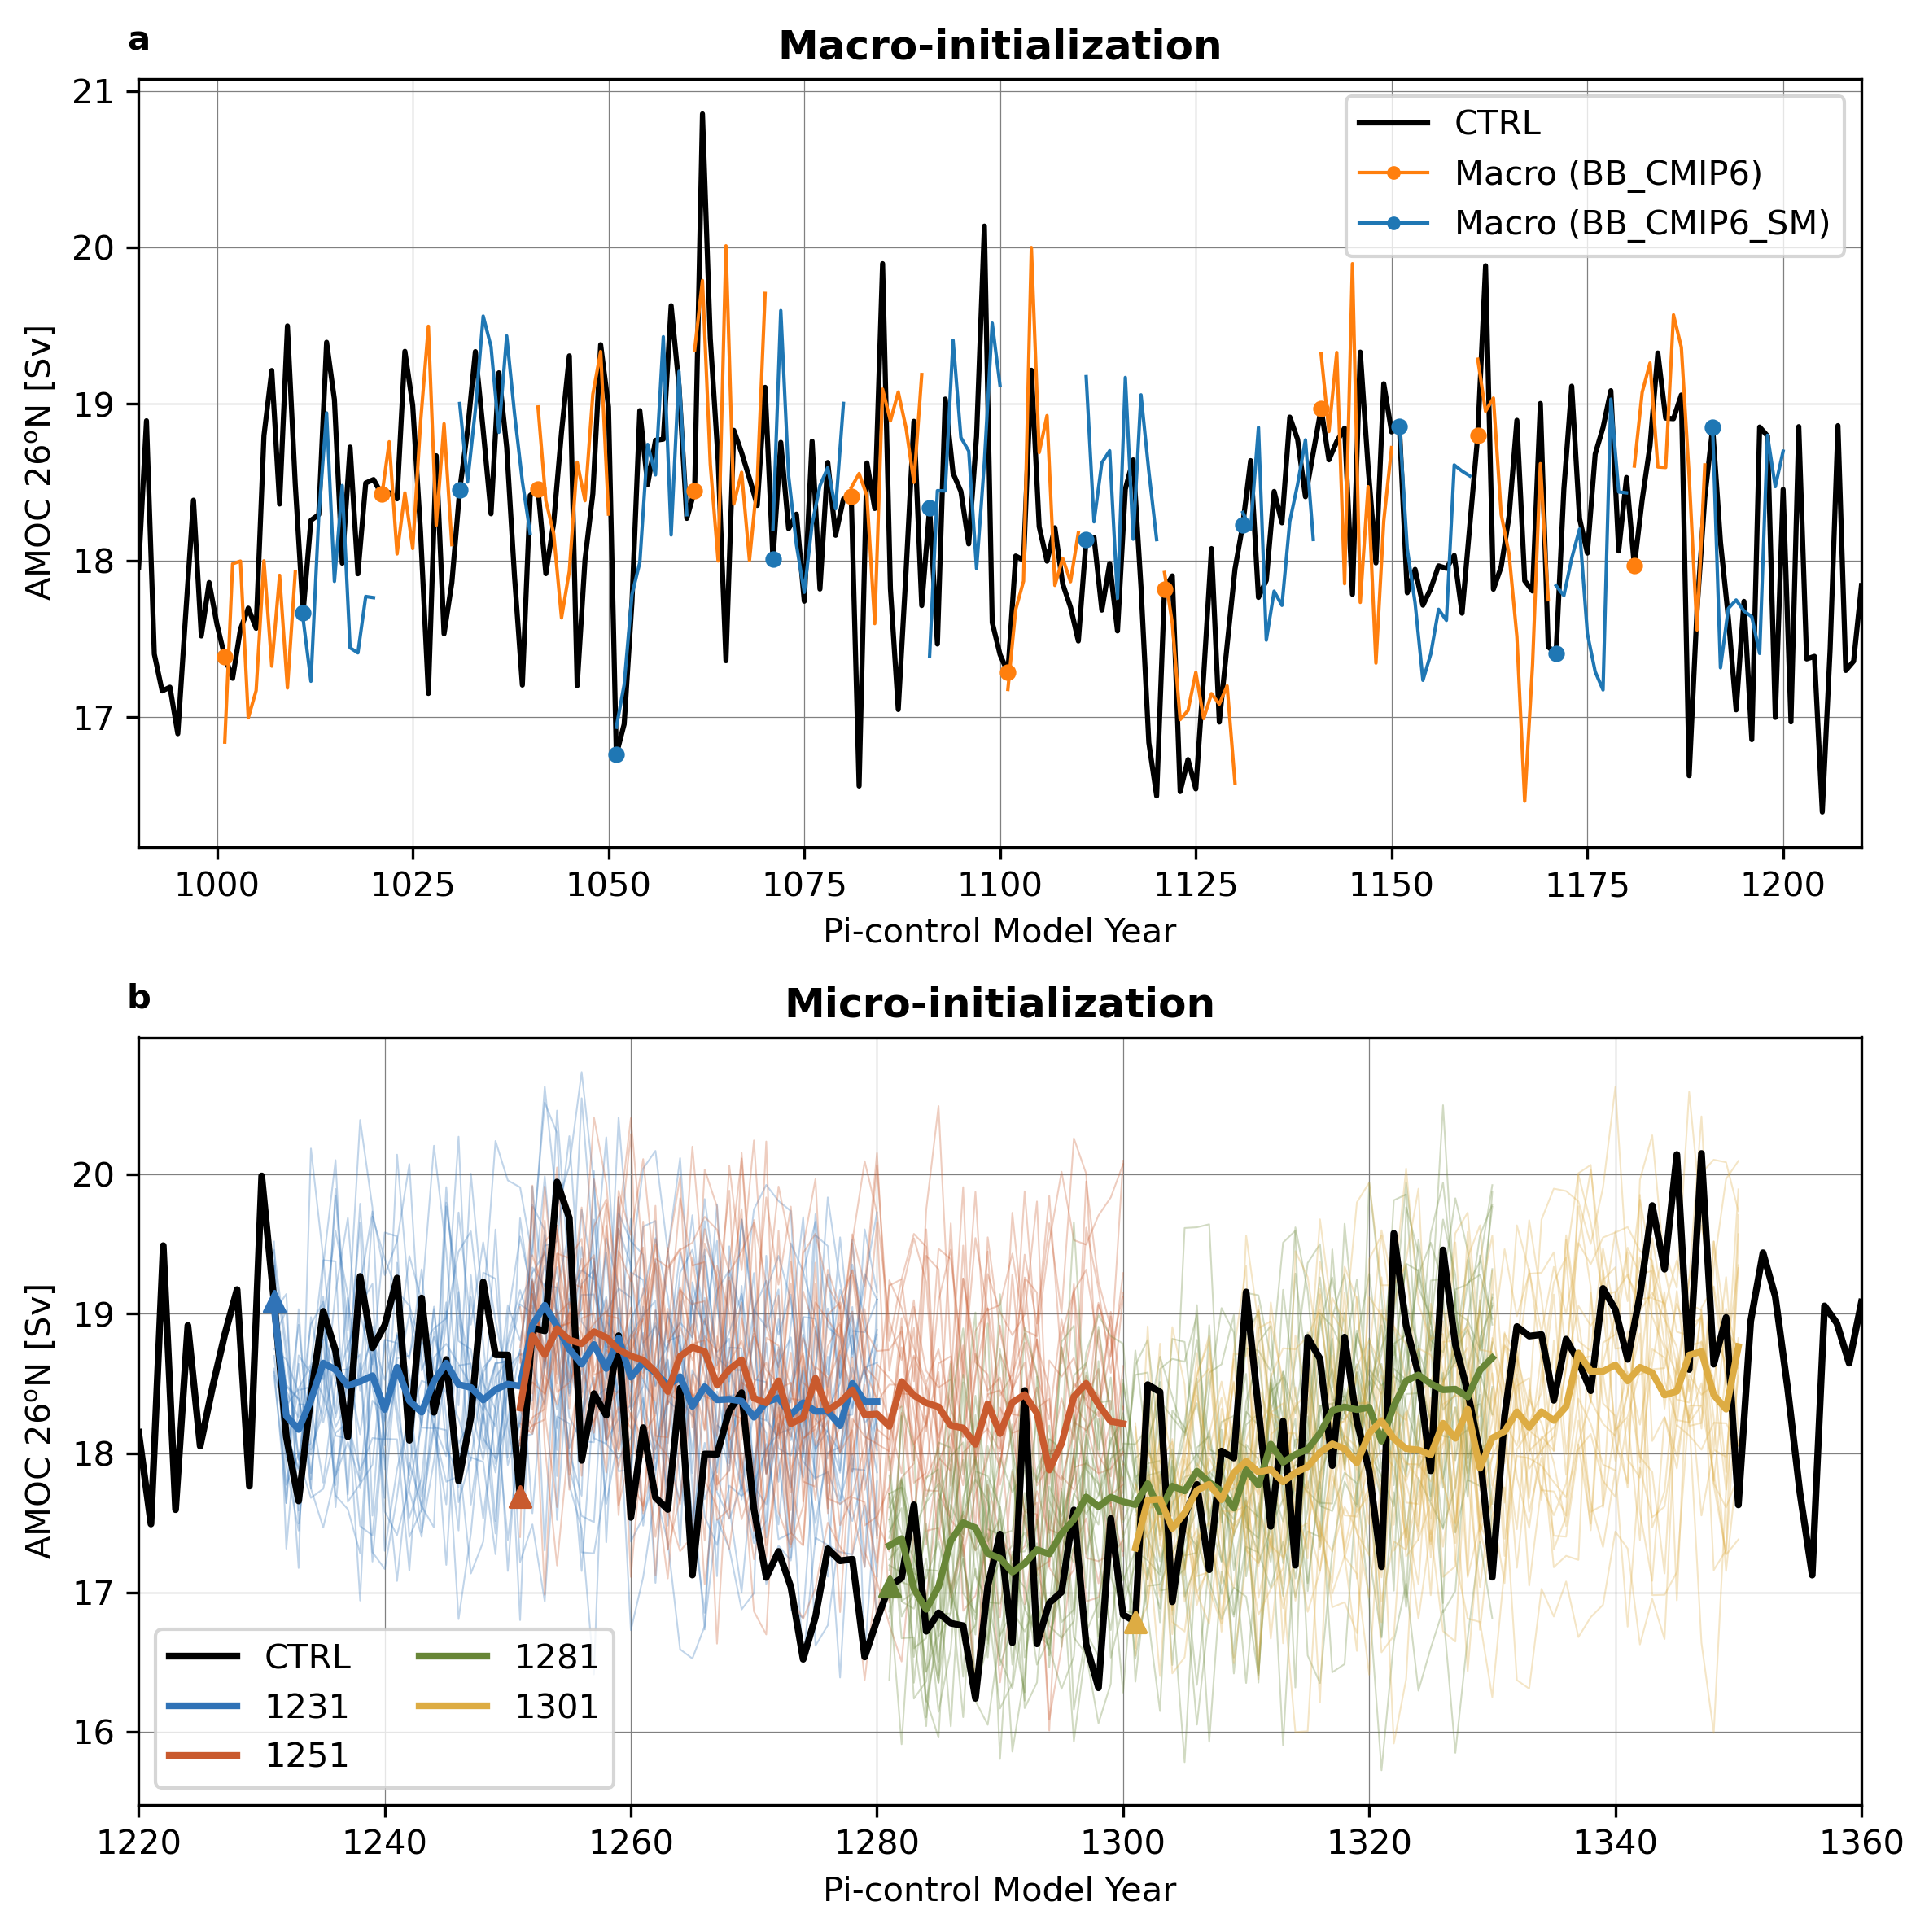

In [17]:
import matplotlib.lines as mlines

syr0,eyr0=990,1210
yrs0=10
syr1,eyr1=1220,1360
yrs1=50

plt.rcParams.update({'font.size': 10})
fig,ax=plt.subplots(2,1,figsize=(8,8),dpi=300,facecolor='w')
#---------------------------------------------------------------------------

macro_syr=[1001,1021,1041,1061,1081,1101,1121,1141,1161,1181,
           1011,1031,1051,1071,1091,1111,1131,1151,1171,1191]
colors = cmaps.hlu_default(np.linspace(0.02,0.8,20))

l0=ts_pi.groupby('time.year').mean().sel(year=slice(syr0,eyr0)).plot(ax=ax[0],color='black',lw=1.5,label='CTRL')
for i,syr in enumerate(macro_syr):
    if i<10 : color='#ff7f0e' #color='#A96324'
    if i>=10: color='#1f77b4' #color='#24538F'
    ax[0].scatter(syr,ts_pi.groupby('time.year').mean().sel(year=syr).values,marker='.',s=60,color=color,zorder=100) 
    ts_macro0.isel(concat_dim=i).assign_coords(year=np.arange(syr,syr+251)).isel(year=slice(0,yrs0)).plot(ax=ax[0],lw=1,label=str(syr),color=color)
    
#---------------------------------------------------------------------------
for i in range(20):
    ts_micro1.isel(concat_dim=i,year=slice(0,yrs1)).plot(ax=ax[1],color='#3073b7',lw=.5,alpha=.3)
for i in range(20):
    ts_micro2.isel(concat_dim=i,year=slice(0,yrs1)).plot(ax=ax[1],color='#c95a2e',lw=.5,alpha=.3)
for i in range(20):
    ts_micro3.isel(concat_dim=i,year=slice(0,yrs1)).plot(ax=ax[1],color='#688637',lw=.5,alpha=.3)
for i in range(20):
    ts_micro4.isel(concat_dim=i,year=slice(0,yrs1)).plot(ax=ax[1],color='#ddac43',lw=.5,alpha=.3)
    
ts_pi.groupby('time.year').mean().sel(year=slice(syr1,eyr1)).plot(ax=ax[1],color='black',lw=2,label='CTRL')
ts_micro1.isel(year=slice(0,yrs1)).mean('concat_dim').plot(ax=ax[1],color='#3073b7',lw=2,label='1231')
ts_micro2.isel(year=slice(0,yrs1)).mean('concat_dim').plot(ax=ax[1],color='#c95a2e',lw=2,label='1251')
ts_micro3.isel(year=slice(0,yrs1)).mean('concat_dim').plot(ax=ax[1],color='#688637',lw=2,label='1281')
ts_micro4.isel(year=slice(0,yrs1)).mean('concat_dim').plot(ax=ax[1],color='#ddac43',lw=2,label='1301')

ax[1].scatter(1231,ts_pi.groupby('time.year').mean().sel(year=1231).values,marker='^',color='#3073b7',zorder=100)
ax[1].scatter(1251,ts_pi.groupby('time.year').mean().sel(year=1251).values,marker='^',color='#c95a2e',zorder=100)
ax[1].scatter(1281,ts_pi.groupby('time.year').mean().sel(year=1281).values,marker='^',color='#688637',zorder=100)
ax[1].scatter(1301,ts_pi.groupby('time.year').mean().sel(year=1301).values,marker='^',color='#ddac43',zorder=100)

#---------------------------------------------------------------------------

ax[0].set_xlim(syr0,eyr0)
ax[0].set_title('Macro-initialization',fontweight='bold')
pi = mlines.Line2D([], [], color='black',lw=1.5,label='CTRL')
smbb = mlines.Line2D([], [], color='#1f77b4',marker='.',lw=1,label='Macro (BB_CMIP6_SM)')
cmip = mlines.Line2D([], [], color='#ff7f0e',marker='.',lw=1,label='Macro (BB_CMIP6)')
#ax[0].legend(handles=[pi,cmip,smbb],bbox_to_anchor=(1.01, 0.5), loc='center left')
ax[0].legend(handles=[pi,cmip,smbb],loc='upper right')
ax[1].set_xlim(syr1,eyr1)
ax[1].set_title('Micro-initialization',fontweight='bold')
#ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
ax[1].legend(ncol=2,loc='lower left')
for i,a in enumerate(ax.flat):
    a.set_ylabel('AMOC 26$^{\mathrm{o}}$N [Sv]')
    a.set_xlabel('Pi-control Model Year')
    a.grid(color='gray',lw=0.3)
    a.text(0.00, 1.05,'%s'%list(string.ascii_lowercase)[i], fontsize = 10, ha='center', va='center', fontweight='bold', transform=a.transAxes)

plt.tight_layout()
#plt.subplots_adjust(hspace=.3)
#plt.show()
plt.savefig('/home/ryamaguchi/amoc_26N_ts_CESM2_CTRL_vs_LE_RY.pdf')